# Heat Equation Machine Learning Solver

Have you ever wondered if a machine learning model can compute the heat distribution inside a room ?

In this Notebook, we are going to see how we can solve the Heat equation with Machine learning and Deep learning models. 

First, we have to import all the librairies we are going to use.

In [4]:
import numpy as np
import time
import os
import scipy as sp
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, SGDRegressor, ElasticNet, MultiTaskElasticNet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor


# import tensorflow as tf
# import tensorflow.python.keras as keras
# from tensorflow.python.keras.models import Sequential
# from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, InputLayer, Dropout, Input #, BatchNormalization, preprocessing 
# from tensorflow.python.keras.optimizers import Adam, SDG

# # solve AttributeError: module 'tensorflow.python.distribute.input_lib' has no attribute 'DistributedDatasetInterface'.
# from tensorflow.python.keras.engine import data_adapter
# def _is_distributed_dataset(ds):
#     return isinstance(ds, data_adapter.input_lib.DistributedDatasetSpec)
# data_adapter._is_distributed_dataset = _is_distributed_dataset



## Reproducability
def set_seed(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    # os.environ['TF_DETERMINISTIC_OPS'] = '1'
    # tf.random.set_seed(seed)

set_seed(42)

## Solving the Heat Equation

In this code, we are solving the stationary heat equation using the finite element method (FEM). The heat equation, which describes the distribution of temperature $u$ for a given heat flux $f$ in a domain $\Omega$, can be written as:

$$
-\alpha \cdot \Delta \mathbf{u} = \mathbf{f} \quad \text{in} \ \Omega,
$$

where:

* $u$ is the temperature field,
* $\alpha$ is the thermal conductivity (assumed to be constant),
* $\mathbf{f}$ is the heat source term (representing the heat flux),
* $\Omega$ is the spatial domain.

The Laplacian $\Delta \mathbf{u}$, which represents the diffusion of heat, is defined in 2D as:

$$
\Delta \mathbf{u} = \frac{\partial^2\mathbf{u}}{\partial x_1^2} + \frac{\partial^2\mathbf{u}}{\partial x_2^2}
$$

To solve this equation numerically using FEM, we discretize the domain into a grid and approximate the solution $u$ at each grid point. The resulting system of equations can be written in matrix form as:

$$
\mathbb{K} \mathbf{u} = \mathbf{f},
$$

where:

* $\mathbb{K}$ is the stiffness matrix that incorporates the thermal conductivity and the geometry of the grid,
* $\mathbf{u}$ is the vector of temperatures at each grid point,
* $\mathbf{f}$ is the vector of heat sources at each grid point.




### Example 

In the code, we simulate a room with two open windows (negative heat flux) windows and two heater (positive flux). We solve the FEM equation by inverting the matrix $\mathbb{K}$ using scipy's linear solver to obtain the temperature distribution $\mathbf{u}$ over the domain. We plot the heat flux, the resulting temperature field, and the gradient of the temperature field.


NB: The heat flux field $\mathbf{f}$ and the temperature field $\mathbf{u}$ are computed as vector in the FEM equation, but they represent the room square domain so they are reshaped as matrices to visualize them.


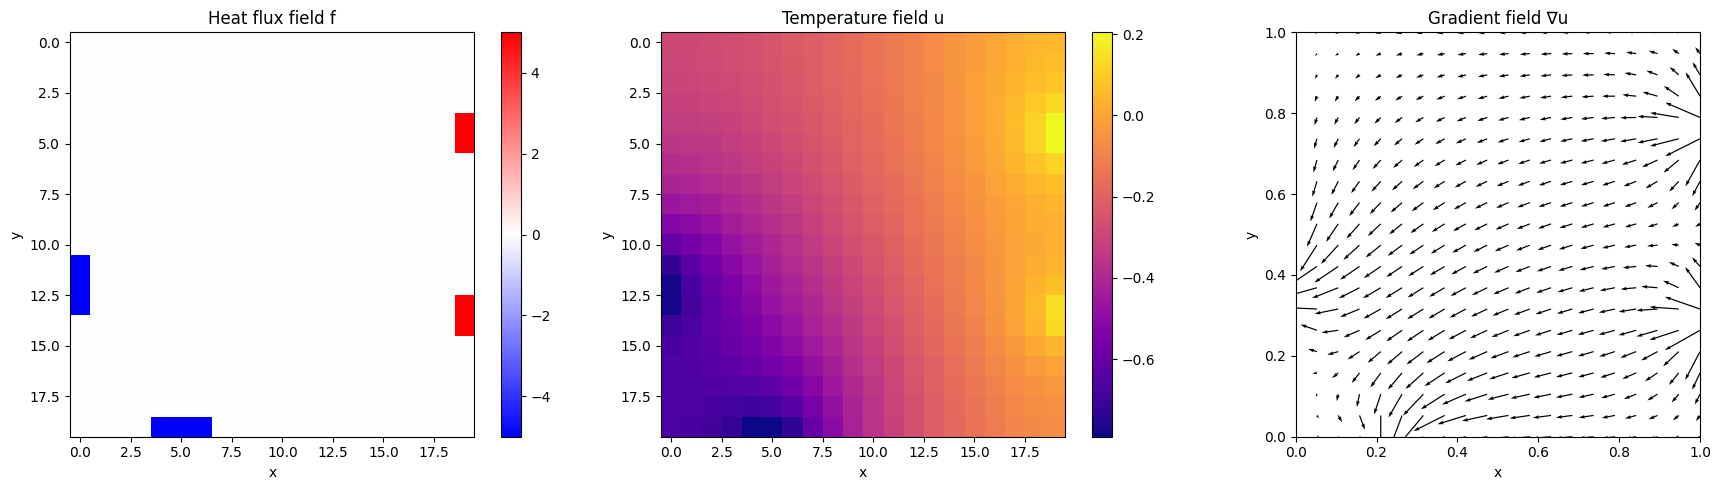

In [ ]:

## HEAT FLUX
def flux(Nx, Ny, x, y, value):
    f = np.zeros((Nx, Ny))
    f[x, y] = value
    return f.flatten()

## FINITE ELEMENTS MATRIX
def get_K(Nx, Ny, L, alpha):
    dx = L / Nx
    dy = L / Ny
    N = Nx * Ny
    K = sp.sparse.lil_matrix((N, N))
    for i in range(Nx):
        for j in range(Ny):
            idx = i * Ny + j

            if i < Nx-1:
                right = idx + Ny
                K[idx, idx] += alpha / dx
                K[idx, right] -= alpha / dx
                K[right, idx] -= alpha / dx
                K[right, right] += alpha / dx

            if j < Ny-1:
                top = idx + 1
                K[idx, idx] += alpha / dy
                K[idx, top] -= alpha / dy
                K[top, idx] -= alpha / dy
                K[top, top] += alpha / dy
    K += 0.1 * sp.sparse.eye(N)  # regularization
    return K

## PARAMETERS
Nx = 20
Ny = 20
N = Nx * Ny
L = 1
alpha = 1.5
K = get_K(Nx, Ny, L, alpha)

## SOURCE TERM (heat flux)
f = flux(Nx, Ny, x=0, y=11, value=-5)
f += flux(Nx, Ny, x=0, y=12, value=-5)
f += flux(Nx, Ny, x=0, y=13, value=-5)
f += flux(Nx, Ny, x=4, y=19, value=-5)
f += flux(Nx, Ny, x=5, y=19, value=-5)
f += flux(Nx, Ny, x=6, y=19, value=-5)
f += flux(Nx, Ny, x=19, y=4, value=5)
f += flux(Nx, Ny, x=19, y=5, value=5)
f += flux(Nx, Ny, x=19, y=13, value=5)
f += flux(Nx, Ny, x=19, y=14, value=5)


## COMPUTE HEAT FIELD
u = sp.sparse.linalg.spsolve(K.tocsr(), f).real


## GRADIENT
dx = L / Nx
dy = L / Ny
u_field = u.reshape((Nx, Ny)).T
f_field = f.reshape((Nx, Ny)).T
grad_u_y, grad_u_x = np.gradient(u_field, dy, dx) 
grad_u_x = -grad_u_x[::-1]
grad_u_y = grad_u_y[::-1]


## GRID for quiver
x = np.linspace(0, L, Nx)
y = np.linspace(0, L, Ny)
X, Y = np.meshgrid(x, y)



## PLOTS
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Heat flux field
im0 = axs[0].imshow(f_field, cmap='bwr', interpolation='nearest')
axs[0].set_title('Heat flux field f')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
fig.colorbar(im0, ax=axs[0])

# Plot 2: Temperature field
im1 = axs[1].imshow(u_field, cmap='plasma', interpolation='nearest')
axs[1].set_title('Temperature field u')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
fig.colorbar(im1, ax=axs[1])

# Plot 3: Gradient field 
axs[2].quiver(X, Y, grad_u_x, grad_u_y, color='black', scale=20)
axs[2].set_title("Gradient field -∇u")
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_xlim([0, L])
axs[2].set_ylim([0, L])
axs[2].set_aspect('equal')

plt.tight_layout()
plt.show()


## Dataset creation

Now, we want to train a model able to generate these temperature fields from the heat flux. To do so, we have to create a synthetic database containing the input heat flux and output heat fields on a 2D square domain. We tested two methods : dataset_mono function that creates all possible mono flux fields and dataset_multi which create up to ten heat sources randomly placed and with random values. 

We compute the associated heat field by computing the finite elements matrix and then solving the system with a classical library (Scipy sparse). We have at the end two lists of matrices, X which contains heats flux on the domain, and Y which contains heat field solutions.

Finally, we nomalize X and Y fields and we separate each dataset in a train and a test datasets.

In [ ]:

def dataset(num):
    """ Mono flux """
    X = []
    Y = []
    for value in tqdm(list(np.linspace(-3, 3, num=num, endpoint=True)), desc="Processing items", unit="item"): 
        for x in range(Nx):
            for y in range(Ny):
                f = flux(Nx, Ny, x, y, value)
                u = sp.sparse.linalg.spsolve(K.tocsr(), f).real 
                X.append(f)
                Y.append(u)
    return X, Y


def dataset_multi(num):
    """ Multi flux """
    X = [] 
    Y = [] 
    for _ in tqdm(range(N*num), desc="Processing items", unit="item"): 
        f = np.zeros(N)
        num_heat_sources = np.random.randint(1, 10)  # Number of heat sources
        positions = np.random.choice(N, num_heat_sources, replace=False)
        values = np.random.rand(num_heat_sources) * 10  # Heat flux values
        f[positions] = values
        u = sp.sparse.linalg.spsolve(K.tocsr(), f).real 
        X.append(f)
        Y.append(u)
    return X, Y



K = get_K(Nx, Ny, L, alpha)

start = time.perf_counter()
X, Y = dataset_multi(100)
end = time.perf_counter()
exe_time = end - start          
print(f"Execution time: {exe_time:.2f}s") 

print(np.shape(X), np.shape(Y))

X = StandardScaler().fit_transform(X) # Attention data leakage !
Y = StandardScaler().fit_transform(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, shuffle=True)


Starting dataset generetion


Processing items: 100%|██████████| 40000/40000 [00:59<00:00, 669.96item/s]


Execution time: 60.03s
(40000, 400) (40000, 400)


## Model selection

In this section, you can choose which model you want to train. We tested many Scikit-Learn models like LinearRegression, Ridge, RidgeCV, Lasso, Gradient Boosting, SVM... We also implemented two Tensorflow Sequential models with Preproccessing (contrast, flips, rotations...), Convolution, Max pooling and Dense layers. 


In [7]:


## SCIKIT-LEARN
model = LinearRegression(n_jobs=-1) # best precision



## TENSORFLOW
# model = keras.Sequential([
#     # Data augmentation
#     preprocessing.RandomContrast(factor=0.5), # contrast change by up to 50%
#     preprocessing.RandomFlip(mode='horizontal'), # flip left-to-right
#     preprocessing.RandomFlip(mode='vertical'), # flip top-to-bottom
#     preprocessing.RandomWidth(factor=0.15), # horizontal stretch
#     preprocessing.RandomRotation(factor=0.10),
#     preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
    
#     # Bloc 1
#     #InputLayer(shape=[N]),
#     Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(Nx, Ny)),
#     Conv2D(32, (3, 3), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.25),
#     # Bloc 2
#     Conv2D(64, (3, 3), padding='same', activation='relu'),
#     Conv2D(64, (3, 3), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.25),
#     # Bloc 3
#     Conv2D(128, (3, 3), padding='same', activation='relu'),
#     Conv2D(128, (3, 3), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.25),

#     # Classification layers
#     Flatten(),
#     Dense(150, activation='relu'),
#     Dropout(0.5),
#     Dense(100, activation='softmax'), #'sigmoid'
# ])

# model = Sequential([
#     Input(shape=(N,)),
#     Dense(256, activation='linear'),
#     Dropout(0.3),
#     Dense(256, activation='linear'),
#     Dropout(0.3),
#     Dense(256, activation='linear'),
#     Dense(256, activation='linear'), # activation='tanh', 'linear', 'sigmoid'
#     Dense(N)
# ]) 


# early_stopping = keras.callbacks.EarlyStopping(patience=5, min_delta=0.001, monitor='loss',restore_best_weights=True)
# rp = keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.2,patience=3, verbose=1,mode="max", min_lr=0.00001)

# mysgd = SGD(learning_rate=0.001, decay=1e-7, momentum=0.9, nesterov=True)
# mysgd = Adam(learning_rate=0.001, decay=0.0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy']) #metrics=['mae']
# print(model.summary())


## Training

We now train the selected model. We calculate their R2 scores and RMSE relative to the test dataset. Finally we plot some randomly chosen heat fields calculated by Finite Elements to compare them with Machine Learning calculated heat fields. Surprisingly, the model with higher precision is Skicit-learn's Linear Regression with a relative error of $10^{-15}$.

Training time: 2.67s

Model's R2 score : 1.0
FINAL RMSE: 2.2798561149001845e-15 



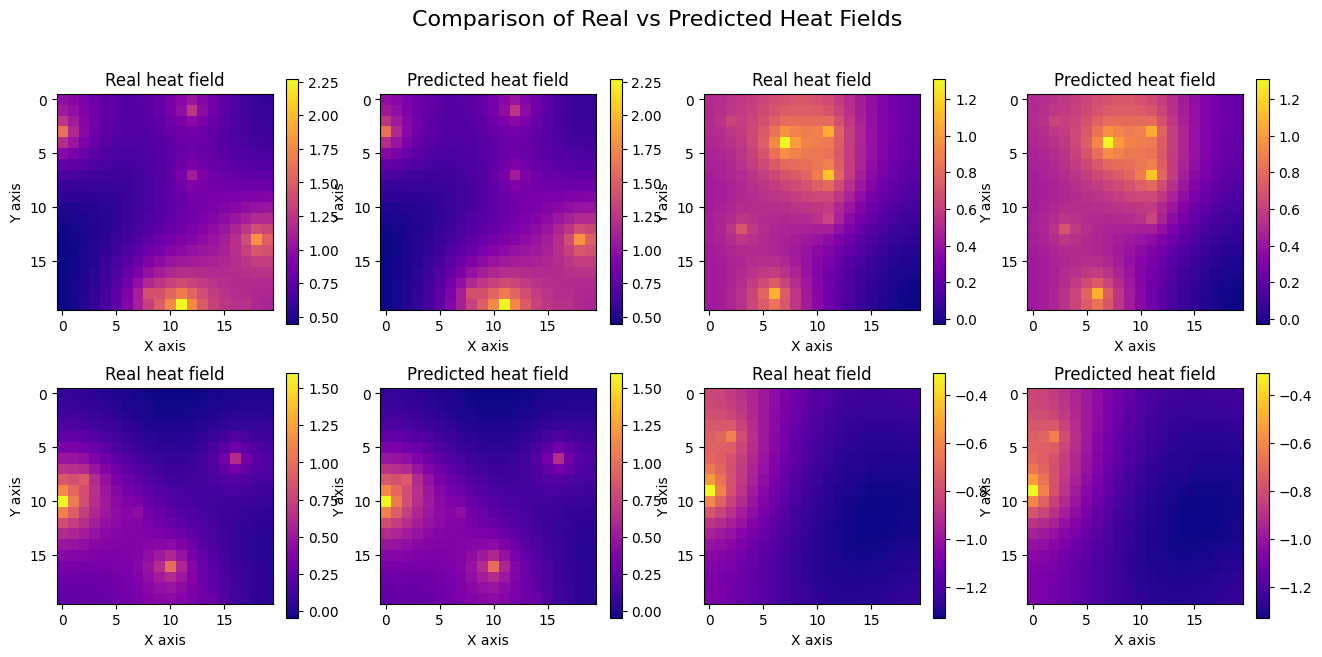

In [ ]:

start = time.perf_counter()
history = model.fit(X_train, Y_train) # Scikit learn model
# history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=N, epochs=200, callbacks=[early_stopping, rp]) # Tensorflow model
end = time.perf_counter()
exe_time = end - start          
print(f"Training time: {exe_time:.2f}s\n") 


# model.save_weights('Machine_Learning/heat.weights.h5')
# plt.plot(history.history['loss'])




### EVALUATION
score = model.score(X_test, Y_test)
print("Model's R2 score :", score)

Y_predict = model.predict(X_test) 
print('FINAL RMSE:', np.sqrt(mean_squared_error(Y_test, Y_predict)), '\n')


## PLOT RANDOM PREDICTIONS
fig, ax = plt.subplots(2, 4, figsize=(16, 7))
fig.suptitle("Comparison of Real vs Predicted Heat Fields", fontsize=16)

for idx, i in enumerate([31, 47, 122, 400]):
    plt.subplot(241 + 2*idx)
    cax_heat = plt.imshow(Y_test[i].reshape((Nx, Ny)).T, cmap='plasma', interpolation='nearest')
    plt.title('Real heat field')
    plt.xlabel("X axis")
    plt.ylabel("Y axis")
    plt.colorbar(cax_heat)

    plt.subplot(242 + 2*idx)
    cax_heat = plt.imshow(Y_predict[i].reshape((Nx, Ny)).T, cmap='plasma', interpolation='nearest')
    plt.title('Predicted heat field')
    plt.xlabel("X axis")
    plt.ylabel("Y axis")
    plt.colorbar(cax_heat)

plt.show()


#### Results :

Scikit learn:  
ExtraTreesRegressor : 0.708  
RandomForestRegressor : 0.675  
LinearRegression : 2.57e-15      
Lasso : 0.997  
Ridge : 1.94e-4  
RidgeCV : 1.94e-5  
ElasticNet : 0.997  
MultiTaskElasticNet : 0.786  
GaussianProcessRegressor : 0.786  
KNeighborsRegressor : 0.907  
Xgboost : 0.64 (too long)  

Tensorflow:  
MSE linear : 0.0088  
MSE tanh : 0.133  
MSE sigmoid : 0.0928  

## Inference time

One interesting result is that the inference time of the model is 5x faster than the classical matrix resolution. We calculated those execution times at the end of the program with timeit module. We also tested different methods to compute the inverse of the FEM matrix K.

In [ ]:
import timeit
f = X_test[120].reshape(-1, 1)

exe_time_inv = np.array(timeit.repeat('np.linalg.inv(K.toarray()) @ f', globals=globals(), number=100, repeat=10)) / 1e2
exe_time_sol = np.array(timeit.repeat('np.linalg.solve(K.toarray(), f)', globals=globals(), number=100, repeat=10)) / 1e2
exe_time_spa = np.array(timeit.repeat('sp.sparse.linalg.spsolve(K.tocsr(), f)', globals=globals(), number=100, repeat=10)) / 1e2
exe_time_mod = np.array(timeit.repeat('model.predict(f.reshape(1, -1))', globals=globals(), number=100, repeat=10)) / 1e2


strings = ['inversion  ', 'solve      ', 'sparse     ', 'model      ']
times = [exe_time_inv, exe_time_sol, exe_time_spa, exe_time_mod]

for str, tim in zip(strings, times):
    print(f"Execution time {str}: {(np.mean(tim)/1e-3):.3f} ms, variance : {(np.var(tim)/1e-9):.2f} ns")

Execution time inversion: : 7.749 ms, variance : 1945.29 ns
Execution time solve :    : 6.238 ms, variance : 6361.92 ns
Execution time sparse :   : 1.274 ms, variance : 212.13 ns
Execution time model :    : 0.208 ms, variance : 1.47 ns
